<a href="https://colab.research.google.com/github/Mhtag/tensorflow/blob/main/07_cnn_colorimage_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cats and Dog image Classification

In [1]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## LOading the Data

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68616192/68606236 [==============================] - 1s 0us/step


In [3]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/train/cats


We'll now assign variables with the proper file path for the training and validation sets.

In [4]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')     # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')     # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')    # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')     # directory with our validation dogs pictures

### Understanding our data

lets look at how many cats and dogs image training and validation data is in our dataset

In [5]:
len(os.listdir(train_cats_dir))

1000

In [6]:
num_cat_tr = len(os.listdir(train_cats_dir))
print('total cat image in training', len(os.listdir(train_cats_dir)))
num_cat_val = len(os.listdir(validation_cats_dir))
print('total cat image in validation', len(os.listdir(validation_cats_dir)) )

print('total dogs image in training', len(os.listdir(train_dogs_dir)))
print('total dogs image in validation', len(os.listdir(validation_dogs_dir)))

total cat image in training 1000
total cat image in validation 500
total dogs image in training 1000
total dogs image in validation 500


## Data Preparing

Images must be formatted into appropriately pre-processed floating point tensors before being fed into the network. The steps involved in preparing these images are:

1. Read images from the disk
2. Decode contents of these images and convert it into proper grid format as per their RGB content
3. Convert them into floating point tensors
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.
5. We will resize each image to a uniform size.

Fortunately, all these tasks can be done using the class **tf.keras.preprocessing.image.ImageDataGenerator**.

In [7]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

after generating train and validation generator **flow_from_directory** methods will load images from disk, apply rescaling and resize them will single line of code.

In [8]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=100,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(150,150),
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [61]:
validation_data_gen = validation_image_generator.flow_from_directory(batch_size=100,
                                                                      directory=validation_dir,
                                                                      target_size=(150,150),
                                                                      shuffle=True,
                                                                      class_mode='binary')

Found 1000 images belonging to 2 classes.


### Vizualizing our train images

In [62]:
sample_image, _ = next(train_data_gen)

The next function returns a batch from train_data. One batch is a tuple of (many images, many labels), we are ignoring label image because we just want to look at the images

In [63]:
def plot_images(img_arry):
  fig, axes = plt.subplots(1,5, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(img_arry, axes):
    ax.imshow(img)
    plt.tight_layout()
  plt.show()

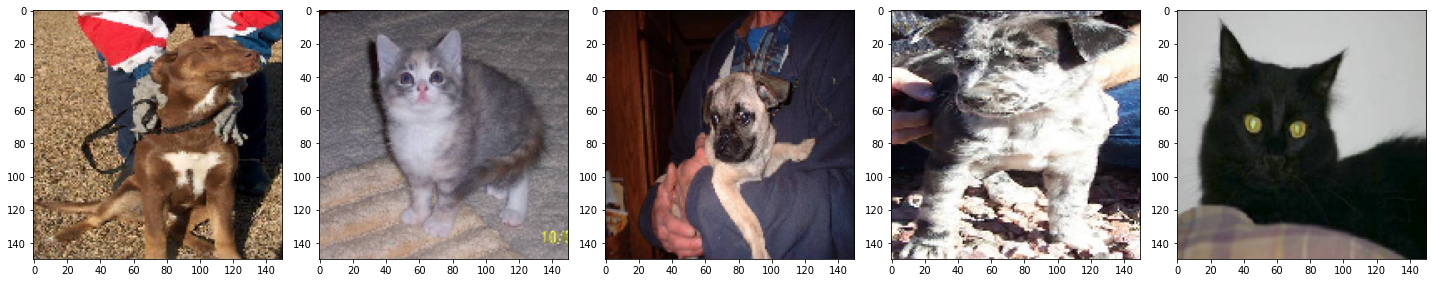

In [64]:
plot_images(sample_image[:5])

## Model Creation

In [65]:
model = tf.keras.Sequential([
                             
  tf.keras.layers.Conv2D(32, (3,3),activation='relu', input_shape=(150,150,3)),
  tf.keras.layers.MaxPooling2D(2,2),

  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),

  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),

  #tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(2)
])

# Compile the model 
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='Adam',
              metrics=['accuracy'])

### Why use **from_logits** in loss function

The **from_logits=True** attribute inform the loss function that the output values generated by the model are not normalized, a.k.a. logits. In other words, the softmax function has not been applied on them to produce a probability distribution. Therefore, the output layer in this case does not have a softmax activation function.

* The softmax function would be automatically applied on the output values by the loss function. Therefore, this does not make a difference with the scenario when you use from_logits=False (default) and a softmax activation function on last layer

In [66]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 8, 8, 128)        

### Train the model

In [67]:
history = model.fit(train_data_gen,
                              epochs=50,
                              steps_per_epoch=20,
                              validation_data=validation_data_gen,
                              validation_steps=10)

Epoch 1/50
20/20 [==============================] - 11s 510ms/step - loss: 0.7126 - accuracy: 0.5160 - val_loss: 0.6902 - val_accuracy: 0.6130
Epoch 2/50
20/20 [==============================] - 10s 490ms/step - loss: 0.6822 - accuracy: 0.5695 - val_loss: 0.6639 - val_accuracy: 0.6500
Epoch 3/50
20/20 [==============================] - 10s 485ms/step - loss: 0.6637 - accuracy: 0.5975 - val_loss: 0.6433 - val_accuracy: 0.6550
Epoch 4/50
20/20 [==============================] - 10s 488ms/step - loss: 0.5991 - accuracy: 0.6830 - val_loss: 0.5721 - val_accuracy: 0.7130
Epoch 5/50
20/20 [==============================] - 10s 487ms/step - loss: 0.5543 - accuracy: 0.7195 - val_loss: 0.5754 - val_accuracy: 0.7010
Epoch 6/50
20/20 [==============================] - 10s 500ms/step - loss: 0.5039 - accuracy: 0.7510 - val_loss: 0.5620 - val_accuracy: 0.7160
Epoch 7/50
20/20 [==============================] - 10s 494ms/step - loss: 0.4812 - accuracy: 0.7645 - val_loss: 0.6675 - val_accuracy: 0.6530

### Vizualizing the traning

In [68]:
df = pd.DataFrame(history.history.values()).T
df

,0,1,2,3
0,0.712649,0.5160,0.690237,0.613
1,0.682200,0.5695,0.663874,0.650
2,0.663740,0.5975,0.643292,0.655
3,0.599121,0.6830,0.572080,0.713
4,0.554326,0.7195,0.575391,0.701
5,0.503939,0.7510,0.562007,0.716
6,0.481178,0.7645,0.667487,0.653
7,0.431444,0.8045,0.540015,0.747
8,0.378066,0.8315,0.556307,0.743
9,0.355785,0.8405,0.551950,0.743


In [69]:
df.columns = history.history.keys()

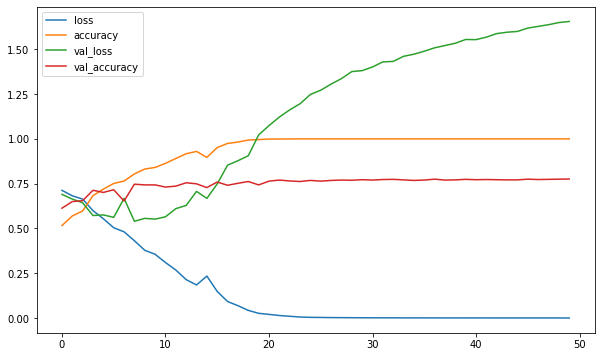

In [70]:
df.plot(figsize=(10,6))